### Import Squewed MNist Dataset and Show Histogram of Classes

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import pandas
from sklearn.preprocessing import StandardScaler

In [4]:
X_y = np.load('../data/skewed_MNIST.npy')
X = X_y[:,:-1]
y = X_y[:,-1]
print(X.shape, y.shape)

(12244, 784) (12244,)


Text(0, 0.5, 'frequency')

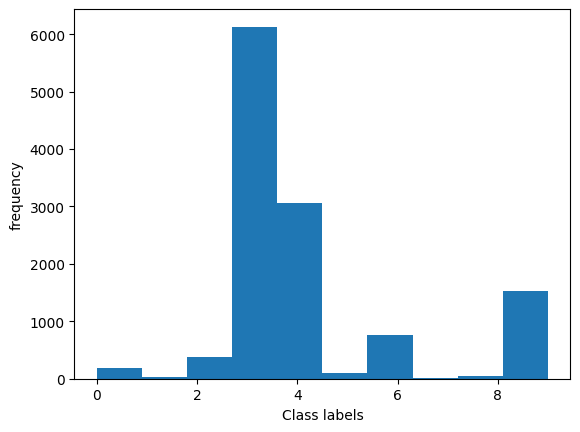

In [5]:
plt.hist(y)
plt.xlabel('Class labels')
plt.ylabel('frequency')

### PCA of Initial Data to 2 Dimensions

In [6]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [7]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

### Fuzzy CMeans Clustering

In [8]:
# v_i = i'th cluster centroid
# p_i = i'th point
# mu_ik = fuzzy parameter for ith point in kth cluster distribution
# J = loss

In [9]:
def find_new_cluster_center(mu, p, m):
    '''
    Function Defined to find new cluster centers (V) using fuzzy matrix
    p( points ) and m (fuzzy constant)
    
    Inputs:
    
    mu: Old mu matrix containing previous fuzzy values, size = (n points, k clusters)
    p: Points of data, size = (n points, d dimensions)
    m: Fuzzy contant, scalar
    
    Outputs:
    
    v: Means of Clusters, each row represents the kth cluster, each column represents
        the d'th dimension
        shape = (k clusters, d dimensions)
    '''
    
    # Initialize v matrix
    v = np.zeros(shape = (mu.shape[1], p.shape[1]))
    
    # Iterate through clusters
    for k in range(mu.shape[1]):
        # Initialize numerator 
        numerator = np.zeros((1, p.shape[1]))
        
        # Iterate through points
        for n in range(p.shape[0]):
            # Multiply points by respective mu index using broadcasting (all p multiply by one mu index)
            numerator += np.power(mu[n,k], m) * p[n,:]
        
        # Sum all values of k'th cluster column in mu matrix    
        denominator = np.sum(np.power(mu[:,k], m))
        
        # Fill k'th cluster row in means matrix
        v[k, :] = numerator / denominator
    
    return v

In [10]:
def update_fuzzy_matrix(mu, p, v, m):
    '''
    Function Defined to update fuzzy matrix which is used to determine
    probabilities of points being in each cluster
    
    Inputs:
    
    mu: Old mu matrix containing previous fuzzy values, size = (n points, k clusters)
    p: Points of data, size = (n points, d dimensions)
    v: Means of Clusters, each row represents the kth cluster, each column represents
        the d'th dimension, shape = (k clusters, d dimensions)
    m: Fuzzy contant, scalar
    
    Outputs:
    
    mu: Updated mu matrix containing previous fuzzy values, size = (n points, k clusters)
    
    '''
    
    # Determine power for denominator
    a = 2 / (m - 1)
    
    # Iterate through all points
    for n in range(p.shape[0]):
        # Iterate through all clusters
        for k in range(mu.shape[1]):
            # Determine numerator for k'th cluster
            num = np.linalg.norm(p[n,:] - v[k, :])
            
            # Initialize sum for the inside of brackets which gets taken to a power
            sum_inside = 0.
            
            # Iterate through all clusters again to represent summation
            for l in range(mu.shape[1]):
                # Find distance between points and cluster means
                den = np.linalg.norm(p[n,:] - v[l,:])
                inside = num / den
                sum_inside += np.power(inside, a)
                
            # Update index
            mu[n,k] = 1. / sum_inside
        
    return mu

In [11]:
def fuzzy_cmeans_loss(mu, p, v, m):
    '''
    Function Defined to determine the loss for Fuzzy C-Means Clustering Algorithm
    
    Inputs:
    
    mu: Old mu matrix containing previous fuzzy values, size = (n points, k clusters)
    p: Points of data, size = (n points, d dimensions)
    v: Means of Clusters, each row represents the kth cluster, each column represents
        the d'th dimension, shape = (k clusters, d dimensions)
    m: Fuzzy contant, scalar
    
    Outputs:
    
    J: Loss of Fuzzy C-Means Clustering Alogorithm, Scalar
    
    '''
    
    # Initialize J
    J = 0
    
    # Iterate through points
    for n in range(p.shape[0]):
        # Iterate through clusters
        for k in range(mu.shape[1]):
            # Find squared distance of point from cluster mean
            norm_val = np.power(np.linalg.norm(p[n,:] - v[k,:]), 2)
            
            # Increment J each point and cluster
            J += np.power(mu[n,k], m) * norm_val
            
    return J

## FCM

In [12]:
# Implment fuzzy c-means clustering from scratch

def fcm(X, n_clusters, max_iter=100, m=2, error=1e-5, random_state=42):
    '''
    Function Defined to determine to implement the Fuzzy C-Means Clustering Algorithm
    on the data X, into n_clusters 
    
    Inputs:
    
    X: Data to be clustered, shape = (n points, d dimensions)
    n_clusters: Scalar of amount of clusters
    max_iteration: Max iterations before exiting algorithm if not converged
    m: Scalar of fuzzy constant
    error: Scalar used to determine Convergence in Algorithm
    random_state: Fuzzy matrix is initially randomly generated, so random state 
                  allows replicability
    
    Outputs:
    
    mu: Final fuzzy matrix: size = (n points, k clusters)
    v: Final cluster means: size = (k clusters, d dimensions)
    
    '''
    # Initialize iteration tracker and loss list
    iter = 0
    J = [1000, 0]
    
    # Generate random fuzzy matrix of values between [0,1)
    mu = np.random.uniform(low=0.25, high=1, size=(X.shape[0], n_clusters))
    
    # Normalize rows to sum to 1, as probability being in all cluster must be 1
    for i in range(mu.shape[0]):
        mu[i,:] = mu[i,:] / np.sum(mu[i,:])
    
    # Iterate until convergence or max iteration hit
    while((np.abs(J[iter]- J[iter+1]) > error) and (iter < max_iter)):
        # Update cluster mean locations
        v = find_new_cluster_center(mu, X, m)
        
        # Calculate new fuzzy matrix
        mu = update_fuzzy_matrix(mu, X, v, m)
        
        # Determine loss for iteration and append to list
        J.append( fuzzy_cmeans_loss(mu, X, v, m) )
        
        # Increment iteration tracker
        iter += 1
        
        # Print to allow visual representation of where algorithm is when running
        print(f'Iteration: {iter},  J: {J[iter+1]:.6f}')
        
    return mu, v

In [13]:
# Run FCM Clustering Algorthm
mu_pca, v_pca = fcm(X_pca, 10, 30)

Iteration: 1,  J: 95507.077003
Iteration: 2,  J: 95494.497680
Iteration: 3,  J: 95418.730856
Iteration: 4,  J: 94973.029019
Iteration: 5,  J: 92734.448140
Iteration: 6,  J: 86588.615974
Iteration: 7,  J: 79894.427166
Iteration: 8,  J: 75768.387246
Iteration: 9,  J: 72325.192929
Iteration: 10,  J: 68049.819201
Iteration: 11,  J: 63696.718789
Iteration: 12,  J: 60194.764874
Iteration: 13,  J: 57554.335156
Iteration: 14,  J: 55735.127817
Iteration: 15,  J: 54525.699261
Iteration: 16,  J: 53667.700354
Iteration: 17,  J: 53007.623069
Iteration: 18,  J: 52483.504267
Iteration: 19,  J: 52073.380488
Iteration: 20,  J: 51761.549118
Iteration: 21,  J: 51526.807458
Iteration: 22,  J: 51346.013078
Iteration: 23,  J: 51200.434021
Iteration: 24,  J: 51077.885696
Iteration: 25,  J: 50971.556285
Iteration: 26,  J: 50877.999667
Iteration: 27,  J: 50795.496480
Iteration: 28,  J: 50723.021618
Iteration: 29,  J: 50659.709379
Iteration: 30,  J: 50604.642075


## Plot PCA Data with Means

Text(0.5, 1.0, 'Fuzzy CMeans Cluster Means with Labeled Points of Squewed PCA M-Nist Dataset')

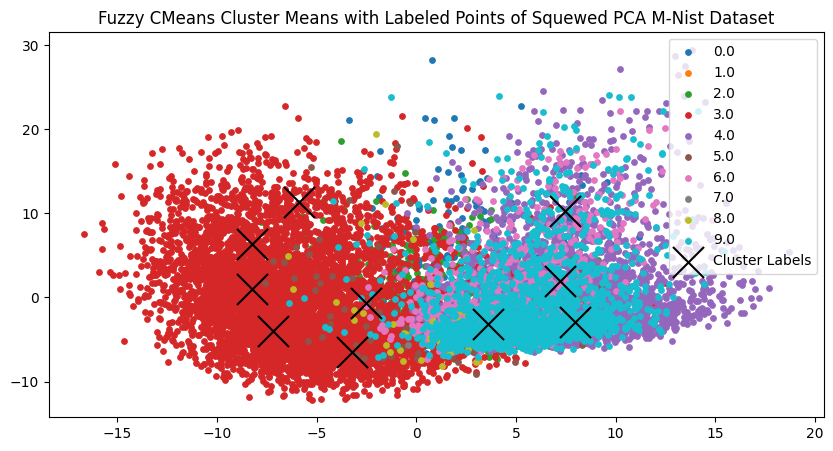

In [14]:
clusters = np.unique(y)

plt.figure(figsize=(10, 5))
for cl_num in np.unique(clusters):
    inds = np.where(y == cl_num)[0]
    plt.scatter(X_pca[inds,0],X_pca[inds,1], marker = 'o', s = 15, label = cl_num)

plt.scatter(v_pca[:, 0], v_pca[:,1], marker='x', c= 'black', s=500, label='Cluster Labels')
plt.legend()
plt.title('Fuzzy CMeans Cluster Means with Labeled Points of Squewed PCA M-Nist Dataset')

In [15]:
# Save means to csv file
v_pca_df = pandas.DataFrame(v_pca)
v_pca_df.to_csv('mu_pca.csv')

## Adjusted Rand Index

In [16]:
def ARI(y, y_pred):
    '''
    Function defined to calculate the Rand Index. This algorithm determines
    the simularities and differences in which points are either within the same cluster
    or not and compares both the true labels and predicted labels. This is required because
    predicted clusters are not assumed to be consistent.
    
    Inputs:
    
    y: True Labels
    y_pred: Predicted Labels
    
    '''
    
    # Initialize comparison values
    n_00 = 0.
    n_11 = 0.
    n_10 = 0.
    n_01 = 0.
    
    # Initialize comparison matrices
    true = np.zeros((len(y), len(y)))
    pred = np.zeros((len(y), len(y)))
    
    # Iterate through labels
    for i in range(true.shape[0]):
        # Iterate through labels
        for j in range(true.shape[0]):
            # Check if points in true labels are in same cluster
            if(y[i] == y[j]):
                true[i,j] = 1
            
            # Check if points in predicted labels are in same cluster
            if(y_pred[i] == y_pred[j]):
                pred[i,j] = 1
    
    # Iterate through upper triangular of true and predicted comparison matrix
    for i in range(true.shape[0]):
        for j in range(i+1, true.shape[1]):
            # Check if true index value is same as predicted index value
            if(true[i,j] == pred[i,j]):
                # Both are in same cluster 
                if(true[i,j] == 1):
                    n_11 += 1.
                # Both are not in same cluster
                else:
                    n_00 += 1.
            # Index values are not the same        
            else:
                # Same clusters in true but different clusters in pred
                if(true[i,j] == 1):
                    n_10 += 1.
                # Different clusters in true but same clusters in pred
                else:
                    n_01 += 1.

    # Calculate rand index value
    ari = (n_00 + n_11) / (n_00 + n_11 + n_10 + n_11)
    
    return ari

In [17]:
y_pred_pca = np.argmax(mu_pca, axis=1)

In [18]:
ari_pca = ARI(y, y_pred_pca)
print(f'ARI Score for PCA FCMeans: {ari_pca:.4f}')

ARI Score for PCA FCMeans: 0.6710


## All Dimensions

In [19]:
# Run FCM on scaled data with 784 dimensions
mu_all, v_all = fcm(X_scaled, 10, 10)

Iteration: 1,  J: 813026.546086
Iteration: 2,  J: 813001.921741
Iteration: 3,  J: 813001.637605
Iteration: 4,  J: 813001.606164
Iteration: 5,  J: 813001.601111
Iteration: 6,  J: 813001.600206
Iteration: 7,  J: 813001.600039
Iteration: 8,  J: 813001.600007
Iteration: 9,  J: 813001.600001


In [20]:
# Save means to csv
v_all_df = pandas.DataFrame(v_all)
v_all_df.to_csv('mu_all.csv')

In [21]:
# Print ARI for X_scaled data
y_pred_all = np.argmax(mu_all, axis=1)
ari_all = ARI(y, y_pred_all)
print(f'ARI Score for All Dimensions FCMeans: {ari_all:.4f}')

ARI Score for All Dimensions FCMeans: 0.6969
